In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the dataset/python Docker image: https://github.com/dataset/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/dataset/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/dataset/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /dataset/temp/, but they won't be saved outside of the current session

/dataset/input/asl-fingerspelling/supplemental_metadata.csv
/dataset/input/asl-fingerspelling/character_to_prediction_index.json
/dataset/input/asl-fingerspelling/train.csv
/dataset/input/asl-fingerspelling/supplemental_landmarks/371169664.parquet
/dataset/input/asl-fingerspelling/supplemental_landmarks/369584223.parquet
/dataset/input/asl-fingerspelling/supplemental_landmarks/1682915129.parquet
/dataset/input/asl-fingerspelling/supplemental_landmarks/775880548.parquet
/dataset/input/asl-fingerspelling/supplemental_landmarks/2100073719.parquet
/dataset/input/asl-fingerspelling/supplemental_landmarks/1650637630.parquet
/dataset/input/asl-fingerspelling/supplemental_landmarks/1471096258.parquet
/dataset/input/asl-fingerspelling/supplemental_landmarks/86446671.parquet
/dataset/input/asl-fingerspelling/supplemental_landmarks/897287709.parquet
/dataset/input/asl-fingerspelling/supplemental_landmarks/333606065.parquet
/dataset/input/asl-fingerspelling/supplemental_landmarks/2057261717.parque

# Sign Language Recognition Challenge

The goal of this competition is to classify American Sign Language (ASL) signs.

The landmarks were extracted from raw videos with the MediaPipe holistic model and are asked to predict the sign from this data.

# 1. DATA OVERVIEW 

In this notebook, we will be exploring and analyzing the dataset. We will start by importing important libraries, loading the data, and giving a brief description of the dataset.

**1.1 Import Libraries** 

In [2]:
import gc

import json
from tqdm import tqdm

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# import data processing and visualisation libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.io as pio
pio.templates.default = "simple_white"

# import tensorflow and keras
import tensorflow as tf
import os

print("Packages imported...")

Packages imported...


All the important packages have been loaded. Now, we'll load the training and supplemental_metadata dataframe.

**1.2 Loading Dataset** 

In [4]:
df = pd.read_csv("/dataset/input/asl-fingerspelling/train.csv")
metadata = pd.read_csv("/dataset/input/asl-fingerspelling/supplemental_metadata.csv")

**1.3 Data Description**

In [5]:
df.head()

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


The phrases in the training set contains random websites/addresses/phone numbers

In [6]:
print(f"Total number of files : {df.shape[0]}")
print(f"Total number of Participant in the dataset : {df.participant_id.nunique()}")
print(f"Total number of unique phrases : {df.phrase.nunique()}")

Total number of files : 67208
Total number of Participant in the dataset : 94
Total number of unique phrases : 46478


In [7]:
metadata.head()

,path,file_id,sequence_id,participant_id,phrase
0,supplemental_landmarks/33432165.parquet,33432165,1535467051,251,coming up with killer sound bites
1,supplemental_landmarks/33432165.parquet,33432165,1535499058,239,we better investigate this
2,supplemental_landmarks/33432165.parquet,33432165,1535530550,245,interesting observation was made
3,supplemental_landmarks/33432165.parquet,33432165,1535545499,38,victims deserve more redress
4,supplemental_landmarks/33432165.parquet,33432165,1535585216,254,knee bone is connected to the thigh bone


The metadata consists of normal sentences only..

**The data consist of:**
path - The path to the landmark file.

file_id - A unique identifier for the data file.

participant_id - A unique identifier for the data contributor.

sequence_id - A unique identifier for the landmark sequence. Each data file may contain many sequences.

phrase - The labels for the landmark sequence. The train and test datasets contain randomly generated addresses, phone numbers, and urls derived from components of real addresses/phone numbers/urls.

Let's checkout Dataframe information more...

In [8]:
# Check the dimensions of the dataset
df.shape

# Check the data types of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67208 entries, 0 to 67207
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            67208 non-null  object
 1   file_id         67208 non-null  int64 
 2   sequence_id     67208 non-null  int64 
 3   participant_id  67208 non-null  int64 
 4   phrase          67208 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.6+ MB


In [9]:
df.describe()

,file_id,sequence_id,participant_id
count,6.720800e+04,6.720800e+04,67208.000000
mean,1.094448e+09,1.072696e+09,119.758154
std,6.395616e+08,6.177372e+08,74.330468
min,5.414471e+06,7.109500e+04,0.000000
25%,5.277082e+08,5.376519e+08,63.000000
50%,1.099408e+09,1.074387e+09,113.000000
75%,1.662743e+09,1.605592e+09,178.000000
max,2.118949e+09,2.147465e+09,254.000000


# 2. EXPLORATORY DATA ANALYSIS (EDA)

**2.1 Inspect the 'PATH' Column**

In [10]:
np.array(list(df["path"].value_counts().to_dict().values())).min()
df["path"].describe().to_frame().T

,count,unique,top,freq
path,67208,68,train_landmarks/5414471.parquet,1000


The path column is simply the path to the landmark file (parquet).

Number unique paths: 68

Minimum Number of repeated path is: 287

Maximum Number of repeated path is: 1000

**2.2 Inspect the 'participant_id' Column**

In [11]:
df["participant_id"].astype(str).describe().to_frame().T

,count,unique,top,freq
participant_id,67208,94,36,1535


The participant_id statistics indicate a varied distribution of data contributions among participants, with some participants contributing more examples than others.

Number of Unique Participants: 94

Average Number of Rows Per Participant: 715.82

Standard Deviation in Counts Per Participant: 230.86

Minimum Number of Examples For One Participant: 1

Maximum Number of Examples For One Participant: 1537

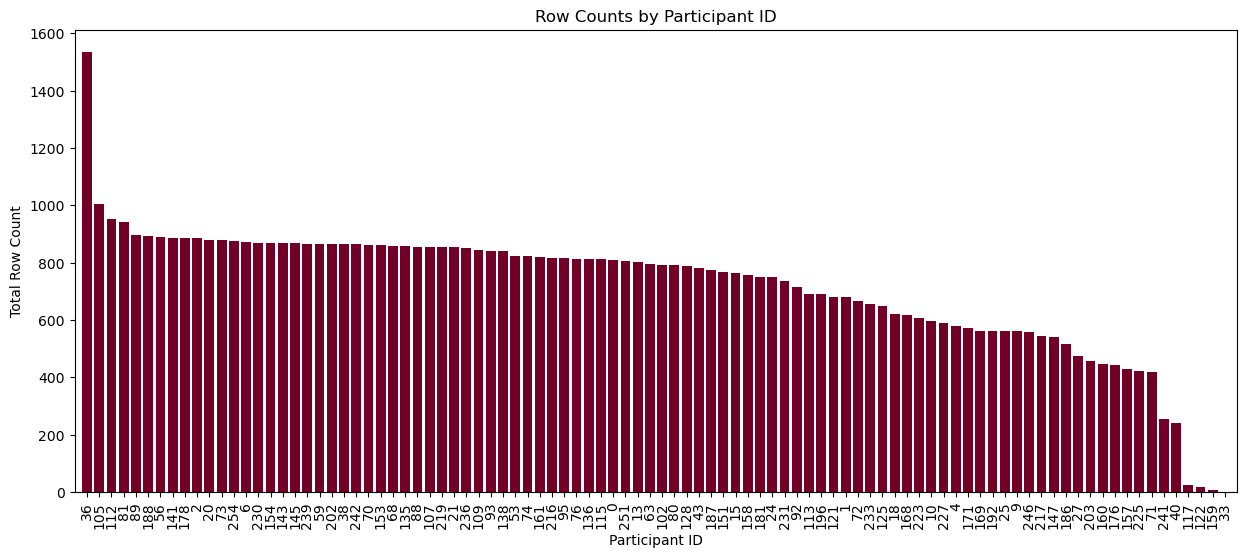

In [12]:
color_scheme = ["#4f000b", "#720026", "#ce4257", "#ff7f51", "#ff9b54"]
#The column is set to strings as it is an ID
df["participant_id"] = df["participant_id"].astype(str)

# Calculate the counts for each participant_id
counts = df["participant_id"].value_counts()

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the histogram
bars = ax.bar(counts.index, counts.values, color=color_scheme[1])

# Set the labels and title
ax.set_xlabel("Participant ID")
ax.set_ylabel("Total Row Count")
ax.set_title("Row Counts by Participant ID")

# Rotate the x-axis labels if needed
plt.xticks(rotation=90, ha='center')
plt.xlim(-1, 94)

# Show the plot
plt.show()

**2.3 Inspect the 'sequence_id' Column**

In [13]:
df["sequence_id"].astype(str).describe().to_frame().T

,count,unique,top,freq
sequence_id,67208,67208,1816796431,1


A unique identifier for the landmark sequence. Each data file may contain many sequences. Every value is unique for every row

**2.4 Inspect the 'phrases' Column**

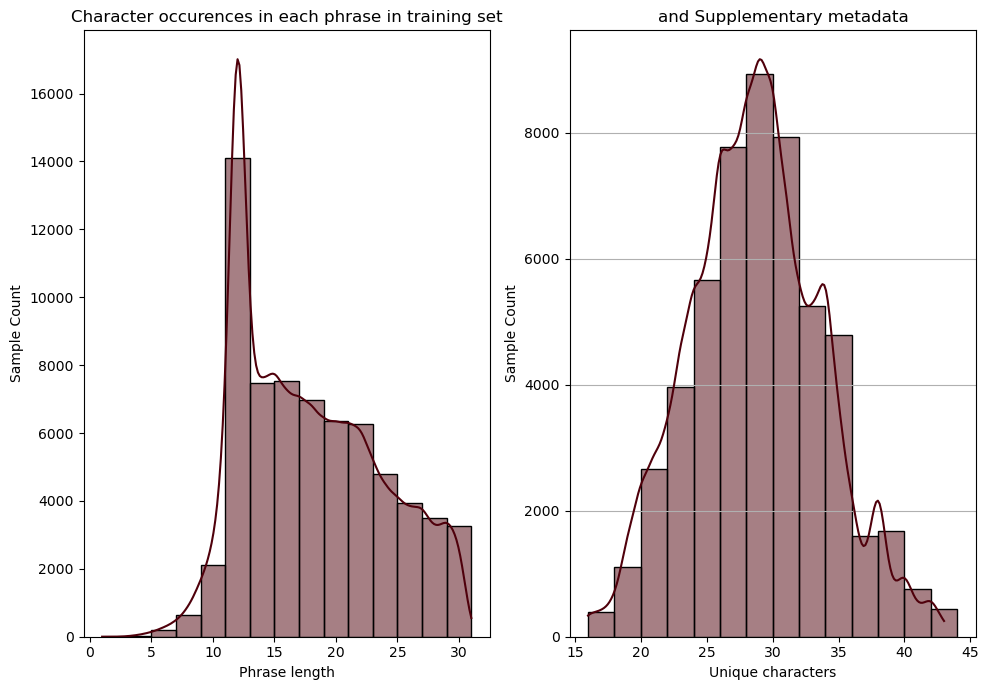

In [14]:
import seaborn as sns

df['phrase_len'] = df.phrase.str.len()
metadata['phrase_len'] = metadata.phrase.str.len()

for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '#000000'  # very light grey

for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#ffffff'  # bluish dark grey

fig, axs = plt.subplots(1, 1, figsize=(10, 7), tight_layout=True)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    axs.spines[s].set_visible(False)

# Remove x, y ticks
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')

# Add padding between axes and labels
axs.xaxis.set_tick_params(pad=5)
axs.yaxis.set_tick_params(pad=10)
color_scheme = ["#4f000b", "#720026", "#ce4257", "#ff7f51", "#ff9b54"]

# Add x, y gridlines
axs.grid(visible=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.6)


plt.subplot(1, 2, 1)
sns.histplot(df.phrase_len, kde=True, binwidth = 2, color=color_scheme[0])
plt.title('Character occurences in each phrase in training set')
plt.xlabel('Phrase length')
plt.ylabel('Sample Count')

plt.subplot(1, 2, 2)
sns.histplot(metadata.phrase_len, kde=True, binwidth = 2, color=color_scheme[0])
plt.title('    and Supplementary metadata')
plt.xlabel('Unique characters')
plt.ylabel('Sample Count')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

**2.4.1 What phrases are we trying to predict?**

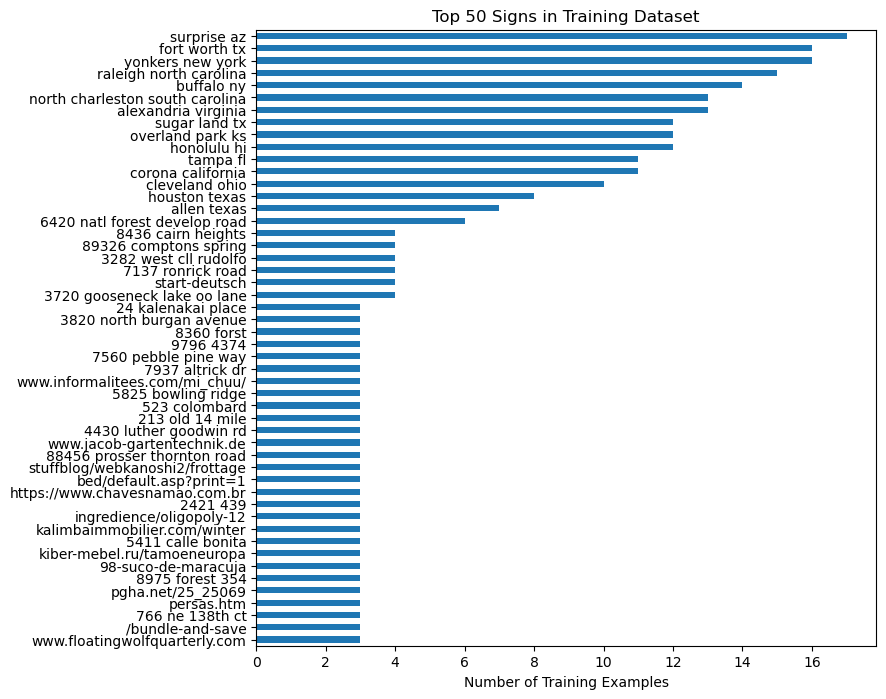

In [15]:
import matplotlib.pyplot as plt
train = pd.read_csv('/dataset/input/asl-fingerspelling/train.csv')
fig, ax = plt.subplots(figsize=(8, 8))
train["phrase"].value_counts().head(50).sort_values(ascending=True).plot(
    kind="barh", ax=ax, title="Top 50 Signs in Training Dataset"
)
ax.set_xlabel("Number of Training Examples")
plt.show()

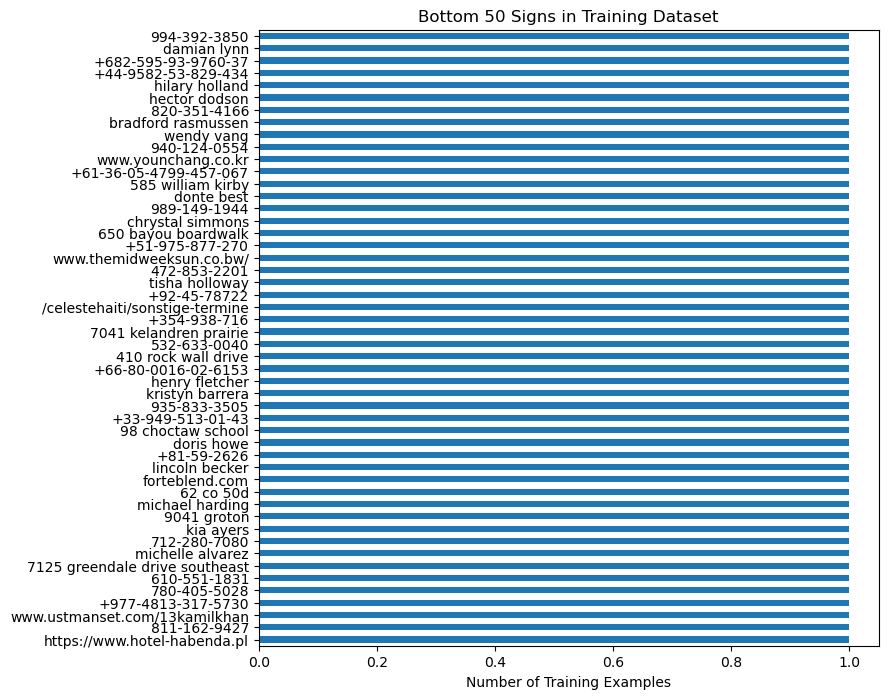

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 8))
train["phrase"].value_counts().tail(50).sort_values(ascending=True).plot(
    kind="barh", ax=ax, title="Bottom 50 Signs in Training Dataset"
)
ax.set_xlabel("Number of Training Examples")
plt.show()

**2.5 Inspecting the 'parquet' column** 

In [17]:
sample = pd.read_parquet("/dataset/input/asl-fingerspelling/train_landmarks/1019715464.parquet")

In [18]:
print(f"Sample shape = {sample.shape}")
sample.sample(10)

Sample shape = (161461, 1630)


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
2006628912,58,0.370001,0.361797,0.366255,0.351666,0.361647,0.363589,0.370067,0.268139,0.372778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983194546,131,0.341312,0.341534,0.341007,0.317367,0.339826,0.336314,0.326607,0.196890,0.320492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979407532,121,0.556440,0.561206,0.558688,0.554106,0.563067,0.565347,0.570429,0.468345,0.574425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989722281,77,0.466396,0.471259,0.466997,0.455071,0.472424,0.472527,0.471051,0.330121,0.471331,...,-0.115283,-0.136426,-0.059105,-0.103667,-0.124793,-0.136684,-0.079189,-0.117896,-0.131313,-0.137909
2005802640,36,0.601450,0.592382,0.592106,0.578084,0.591811,0.590698,0.587382,0.490032,0.584414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984822205,6,0.684869,0.672740,0.679165,0.659357,0.671088,0.671264,0.673862,0.574964,0.673281,...,-0.128980,-0.150374,-0.076840,-0.120516,-0.139159,-0.146679,-0.095557,-0.133389,-0.146541,-0.152953
1981135706,69,0.287177,0.279451,0.284275,0.262218,0.277224,0.275486,0.272608,0.167537,0.269175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993145713,62,0.678040,0.678271,0.679028,0.674818,0.680904,0.685969,0.699280,0.581530,0.707013,...,-0.179901,-0.168911,-0.108286,-0.190325,-0.166965,-0.133106,-0.142954,-0.191276,-0.172816,-0.148198
1989094153,49,0.742046,0.750578,0.746951,0.753730,0.756503,0.765601,0.788172,0.637316,0.804710,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
sample.describe()

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
count,161461.000000,160278.000000,160278.000000,160278.000000,160278.000000,160278.000000,160278.000000,160278.000000,160278.000000,160278.000000,...,73394.000000,73394.000000,73394.000000,73394.000000,73394.000000,73394.000000,73394.000000,73394.000000,73394.000000,73394.000000
mean,104.867541,0.554182,0.548478,0.551414,0.536308,0.548015,0.548732,0.551513,0.444876,0.551947,...,-0.135173,-0.144074,-0.067872,-0.128156,-0.138056,-0.131727,-0.086140,-0.131659,-0.135321,-0.128832
std,86.207191,0.129534,0.126287,0.128008,0.127805,0.126163,0.126821,0.129227,0.134529,0.130194,...,0.070175,0.076910,0.046918,0.062506,0.067768,0.074496,0.049549,0.061519,0.066956,0.073019
min,0.000000,0.103906,0.107426,0.106770,0.087026,0.106714,0.104606,0.097967,-0.068946,0.085629,...,-0.804502,-0.911767,-0.452172,-0.646407,-0.789027,-0.892902,-0.471836,-0.653871,-0.763084,-0.848687
25%,41.000000,0.489872,0.485121,0.487680,0.472735,0.484261,0.484653,0.486007,0.381312,0.485465,...,-0.166090,-0.177454,-0.088966,-0.157679,-0.169352,-0.165617,-0.109835,-0.161745,-0.167367,-0.163408
50%,86.000000,0.572730,0.566025,0.569351,0.554663,0.565580,0.566387,0.569752,0.468610,0.570553,...,-0.121772,-0.129739,-0.058184,-0.117250,-0.125355,-0.118194,-0.076272,-0.120762,-0.123404,-0.116560
75%,146.000000,0.639833,0.630259,0.635003,0.619101,0.629602,0.631083,0.636369,0.533060,0.637612,...,-0.089064,-0.092906,-0.036033,-0.086171,-0.092268,-0.080486,-0.051808,-0.089323,-0.089033,-0.077901
max,750.000000,1.022021,1.026810,1.023538,0.997192,1.024715,1.018555,1.002975,0.871772,1.005253,...,0.253719,0.281694,0.152119,0.191191,0.229842,0.270752,0.139569,0.167341,0.215793,0.253798


MULTI_HAND_LANDMARKS Collection of detected/tracked hands, where each hand is represented as a list of 21 hand landmarks and each landmark is composed of x, y and z. x and y are normalized to [0.0, 1.0] by the image width and height respectively. z represents the landmark depth with the depth at the wrist being the origin, and the smaller the value the closer the landmark is to the camera. The magnitude of z uses roughly the same scale as x.

Inaddition, there are few negative coordinates above. negative values are not expected for x and y perhaps. It is also important to note that for a good chunk of the video either or both hands will not be visible or in other words, will not have any landmark data.

Lets extract the columns and check the nans in either hands

In [20]:
def get_cols(df, words_pos, words_neg=[], ret_names=True):
    cols = []
    names = []
    for col in df.columns:
        # Check if column name contains all words
        if all([w in col for w in words_pos]) and all([w not in col for w in words_neg]):
            cols.append(df[col])  # Append the entire column to the list
            names.append(col)

    if ret_names:
        return cols, names
    else:
        return cols

In [21]:
# Landmark Indices for Left/Right hand without z axis in raw data
LH_Index, LEFT_HAND_NAME = get_cols(sample, ['left_hand'], ['z'])
RH_Index,RIGHT_HAND_NAME = get_cols(sample, ['right_hand'], ['z'])
#RIGHT_HAND_NAMES0.insert(0, "frame")
LEFT_HAND_NAME.insert(0, "frame")
COLUMNS = np.concatenate((LEFT_HAND_NAME, RIGHT_HAND_NAME))

N_COLS0 = len(COLUMNS)

print(f'Total number of columns: {N_COLS0}')

Total number of columns: 85


In [22]:
RIGHT_HAND = sample.loc[:, RIGHT_HAND_NAME] 
LEFT_HAND = sample.loc[:, LEFT_HAND_NAME] 
RIGHT_HAND

,x_right_hand_0,x_right_hand_1,x_right_hand_2,x_right_hand_3,x_right_hand_4,x_right_hand_5,x_right_hand_6,x_right_hand_7,x_right_hand_8,x_right_hand_9,...,y_right_hand_11,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1975433633,0.223376,0.314379,0.381249,0.422019,0.463780,0.349893,0.390788,0.424455,0.453150,0.276916,...,0.515195,0.482174,0.626820,0.566435,0.522641,0.485579,0.653875,0.612873,0.584119,0.557135
1975433633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975433633,0.229610,0.323558,0.391224,0.428452,0.472937,0.348827,0.397519,0.435018,0.458869,0.275968,...,0.506925,0.470164,0.622517,0.556892,0.511068,0.470564,0.648757,0.601616,0.567502,0.535259
1975433633,0.233477,0.324557,0.396712,0.433438,0.469773,0.347876,0.397283,0.439693,0.467815,0.277466,...,0.506720,0.469948,0.621060,0.556469,0.510893,0.470012,0.647568,0.599290,0.565760,0.533937
1975433633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008677531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008677531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008677531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
print(f"Percentage of nulls in Left Hand data = {100*np.mean(LEFT_HAND['x_left_hand_0'].isnull()):.02f} %")
print(f"Percentage of nulls in Right Hand data = {100*np.mean(RIGHT_HAND['x_right_hand_0'].isnull()):.02f} %")

Percentage of nulls in Left Hand data = 89.13 %
Percentage of nulls in Right Hand data = 54.54 %


# 3. Preprocessing Data 

In [24]:
sample = pd.read_parquet('/dataset/input/asl-fingerspelling/train_landmarks/1021040628.parquet')
LANDMARK_FILES_DIR = "/dataset/input/asl-fingerspelling/train_landmarks"
TRAIN_FILE = "/dataset/input/asl-fingerspelling/train.csv"
label_map = json.load(open("/dataset/input/asl-fingerspelling/character_to_prediction_index.json", "r"))

In [25]:
len(label_map)

59

So there are 59 characters in total in the vocabulary. :

- alphabets a-z : total 26 characters
- digits : 0-9 , 10 in total
- The rest are special characters.

In [26]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df

In [27]:
import multiprocessing as mp
import pandas as pd
import torch
import numpy as np

# Function to process a single parquet file
def process_parquet(row):
    path = os.path.join("/dataset/input/asl-fingerspelling", row[1].path)
    data_columns = COLUMNS
    landmark_df = pd.read_parquet(path, columns=data_columns)

    # Group the landmarks by sequence_id
    grouped_landmarks = landmark_df.groupby('sequence_id')

    # Initialize empty lists to store features and labels
    features = []
    labels = []

    # Iterate over each sequence_id
    for sequence_id, group in grouped_landmarks:
        # Get the label for the sequence
        phrase = df.loc[df['sequence_id'] == sequence_id, 'phrase'].iloc[0]

        # Map each letter in the phrase using label_map
        mapped_phrase = [letter for letter in phrase]
        # Create a new Series with sequence and mapped_phrase
        result_series = pd.DataFrame({'sequence_id': sequence_id, 'mapped_phrase': mapped_phrase}) 
        result_series['label'] = result_series['mapped_phrase'].map(label_map).astype(np.int8)  

        # Convert the label Series to a list
        #label_list = result_series['label'].tolist()

        # Initialize an empty feature vector for the sequence
        sequence_features = []
        
        # Iterate over each landmark index
        for landmark_index in range(20):
            # Generate feature names for x, y, z coordinates
            x_feature = f'x_right_hand_{landmark_index}'
            y_feature = f'y_right_hand_{landmark_index}'

            # Get the x, y, z coordinates for the landmark
            x = group[x_feature].values.astype(np.float16)
            y = group[y_feature].values.astype(np.float16)

            # Replace NaN values with 0
            x[np.isnan(x)] = 0.0
            y[np.isnan(y)] = 0.0
                        
            # Perform feature transformations or calculations
            x = torch.tensor(x).contiguous().view(-1, x.shape[0])
            y = torch.tensor(y).contiguous().view(-1, y.shape[0])
            
            x_mean = torch.mean(x, 0) 
            y_mean = torch.mean(y, 0) 

            x_std = torch.std(x, 1) 
            y_std = torch.std(y, 1) 

            # Add the calculated features to the sequence feature vector
            sequence_features = torch.cat([x_mean, y_mean,x_std,y_std], axis=0)
            #sequence_features = torch.where(torch.isnan(sequence_features), torch.tensor(0.0, dtype=torch.float32), sequence_features)

            diff = 3258 - sequence_features.shape[0]
            if diff > 0:
                padding = torch.zeros(diff)
                sequence_features = torch.cat((sequence_features, padding))
            
            features = sequence_features[:3258].cpu().numpy()
            return features, result_series['label']

if __name__ == '__main__':
    df = pd.read_csv(TRAIN_FILE)
    df = reduce_mem_usage(df) 
    df2 = df.head(30)

    max_label_length = 30
    all_features = np.zeros((df.shape[0], 3258))
    labels = np.zeros((df.shape[0], max_label_length))
    #all_features = []
    #labels = []

    # Process parquet files in parallel
    with mp.Pool() as pool:
        results = pool.imap(process_parquet, df.iterrows(), chunksize=250)
        for i, (x, y) in tqdm(enumerate(results), total=df.shape[0]):
            all_features[i, :] = x
            labels[i, :len(y)] = y.values.reshape(1, -1)

    # Print the shapes of the tensors
    np.save("feature_data.npy", all_features)
    np.save("feature_labels.npy", labels)

    print("Features tensor shape:", all_features.shape)
    print("Labels tensor shape:", labels.shape)

100%|██████████| 67208/67208 [2:04:33<00:00,  8.99it/s]


Features tensor shape: (67208, 3258)
Labels tensor shape: (67208, 30)


# 4. Evaluation Metric

The Levenshtein distance, also known as the edit distance, quantifies the dissimilarity between two strings by measuring the minimum number of single-character edits (insertions, deletions, or substitutions) required to transform one string into another. This metric provides a valuable measure of how well the predicted ASL sequence matches the ground truth or reference sequence.

To calculate the Levenshtein distance for ASL recognition, the predicted ASL sequence and the reference or ground truth sequence are compared character by character. Each character is treated as a token, representing a specific sign or gesture. The Levenshtein distance is then computed by determining the minimum number of edit operations needed to transform the predicted sequence into the reference sequence or vice versa.

The evaluation metric for this contest is the normalized total Levenshtein distance. The formula for calculating the metric is as follows:

Metric = (N - D) / N

Where:

N is the total number of characters in the labels.
D is the total Levenshtein distance.

To calculate the metric, you would need the labels data and the predicted sequence. The Levenshtein distance measures the minimum number of single-character edits (insertions, deletions, or substitutions) required to change one sequence into another.

In the given context, it seems that the labels are provided in the "phrase" column of the [train/supplemental_metadata].csv file. The predicted sequence can be obtained from the landmark data files in the [train/supplemental]_landmarks/ directory.

To calculate the total Levenshtein distance, you would need to compare each character in the labels with the corresponding character in the predicted sequence and count the number of edits required.

Finally, you can plug the values of N (total characters in the labels) and D (total Levenshtein distance) into the formula to compute the metric. The resulting value will give you an indication of the accuracy of the predicted sequence compared to the labels, with higher values indicating better performance.

Note: Since the specific implementation details are not provided, you would need to write code or use existing libraries to calculate the Levenshtein distance and implement the metric calculation

The LD is explained in depth in this discussion

In [28]:
from Levenshtein import distance
#Using the dynamic programming approach for calculating the Levenshtein distance

def levenshteinDistanceDP(token1, token2):
    # Create a 2-D matrix 
    distances = np.zeros((len(token1) + 1, len(token2) + 1))
    
    #Initialize the first row and column, Row index is fixed to 0 and the variable t1 is used to define the column index. 
    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1
        
    #Column index of the distances array is now fixed to 0, while the loop variable t2 is used to define the index of the rows
    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
    a = 0
    b = 0
    c = 0
    
    #Inside the loops the distances are calculated for all combinations of prefixes from the two words. 
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
                
            #If the two characters are not equal, then the distance in the current cell is equal to the
            #minimum of the three existing values in the 2 x 2 matrix after adding a cost of 1
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1
                    
    #Print its contents 
    printDistances(distances, len(token1), len(token2))
    
    #returning the calculated distance between the two words
    return distances[len(token1)][len(token2)]
def printDistances(distances, token1Length, token2Length):
    for t1 in range(token1Length + 1):
        for t2 in range(token2Length + 1):
            print(int(distances[t1][t2]), end=" ")
        print()
        
phase1 = '3 creekhouse'
phase2 = 'scales/kuhaylah'

#Calling levenshteinDistanceDP function, 
#It returns an integer representing the distance between them

print("Printing The Distance Matrix:")
print(f" \nThe Levenshtein distance of phrases = {levenshteinDistanceDP(phase1, phase2):.02f} ")

Printing The Distance Matrix:
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
1 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
2 2 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
3 3 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
4 4 3 3 4 5 6 7 8 9 10 11 12 13 14 15 
5 5 4 4 4 4 5 6 7 8 9 10 11 12 13 14 
6 6 5 5 5 4 5 6 7 8 9 10 11 12 13 14 
7 7 6 6 6 5 5 6 6 7 8 9 10 11 12 13 
8 8 7 7 7 6 6 6 7 7 7 8 9 10 11 12 
9 9 8 8 8 7 7 7 7 8 8 8 9 10 11 12 
10 10 9 9 9 8 8 8 8 7 8 9 9 10 11 12 
11 10 10 10 10 9 8 9 9 8 8 9 10 10 11 12 
12 11 11 11 11 10 9 9 10 9 9 9 10 11 11 12 
 
The Levenshtein distance of phrases = 12.00 
